# Let's try source injection in Gen 3

In [1]:
# Imports
# Generic python packages
import numpy as np
import pylab as plt
from tqdm.notebook import tqdm
import pandas as pd
import sqlite3
import sqlalchemy 
from astropy.time import Time

import desclamp as lamp

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)
# Some plotting tools
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
from matplotlib.transforms import Affine2D

from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from lsst.afw.image import MultibandExposure
import lsst.geom as geom
import lsst.afw.coord as afwCoord
import lsst.sphgeom as sphgeom
import lsst.geom as afwGeom
import astropy.units as u
import astropy
from astropy.time import Time
afwDisplay.setDefaultBackend('matplotlib')

# imports python's garbage collector
import gc                            

import warnings
warnings.simplefilter("ignore", category=UserWarning)

# Pull calexp images

In [2]:
def remove_figure(fig):
    """Remove a figure to reduce memory footprint. """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()      # clear the figure
    plt.close(fig) # close the figure
    gc.collect()   # call the garbage collector
    
def is_in_region(ra, 
                 dec, 
                 butler, 
                 time=None, 
                 skymap=None, 
                 regions=[{"tract": [4848], 
                           "patches": [35,36,42,43], 
                           "time": [[Time('2022-01-01T03:21:12.552', 
                                         format='isot', 
                                         scale='utc'),
                                    Time('2023-12-31T06:55:22.651', 
                                         format='isot', 
                                         scale='utc')]]}]):
    """
    Returns True if a set of coordinates (including time) is in a given region.
    
    Parameters
    ----------
    ra, dec: float
        Ra and Dec Coordinates.
    butler: lsst.daf.persistence.Butler
        servant providing access to a data repository
    time: astropy.time
        time of observation (event).
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    regions: array
        Array of dictionnaries containing available patches, tracts and time limits.
        
    Returns
    -------
    is_in: bool
        True if ‘(ra, dec)‘ is in ‘region‘
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    
    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tract = skymap.findTract(radec)
    patch = tract.findPatch(radec)
    
    for r in regions:
        if tract.getId() in r["tract"]:
            if patch.getSequentialIndex() in r["patches"]:
                if time is not None:
                    if np.size(r["time"]) > 0:
                        for span in r["time"]:
                            if (time < span[1]) and (time > span[0]):
                                return True
                else:
                    return True

    return False
    

def query_transient(registry, radec, timespan, myband = 'r', mesh_lvl=1, time_limit=None):
    """ Query the registry for temporal and spatial traget.
    
    Parameters
    ----------
    radec: `SkyCoord` object
        the coordinates of the object to query

    timespan: `dafButler.timespan` object
        time span for the object.
        
    mesh_lvl(optional): int
        the level at which one sky pixel is about five arcmin across.
    
    """
    
    # Get the hierarchical triangular mesh (HTM) for the position to query. Initialize a sky pixelization.
    pixelization = sphgeom.HtmPixelization(mesh_lvl)
    # Find the HTM ID for a desired sky coordinate.
    htm_id = pixelization.index(sphgeom.UnitVector3d(sphgeom.LonLat.fromDegrees(
                            radec.ra.value, radec.dec.value)))
    
    # Query the datasets.
    datasetRefs = registry.queryDatasets("calexp", htm20=htm_id, 
                                     where=f"visit.timespan OVERLAPS my_timespan AND band = myband",
                                     bind={"my_timespan": timespan, "myband": myband})
    
    return datasetRefs


# Prepare catalogs and butler:

In [3]:
# This is the repo containing the Run3.1i DDF data:
repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo'

# These are the collections containing the Y1 processed visit images, etc..
collections = ['u/descdm/sfp_ddf_visits_part_00',
               'u/descdm/sfp_ddf_visits_part_01',
              ]

# Create a data butler and registry
butler = dafButler.Butler(repo, collections=collections)
skymap = butler.get("skyMap")

registry = butler.registry

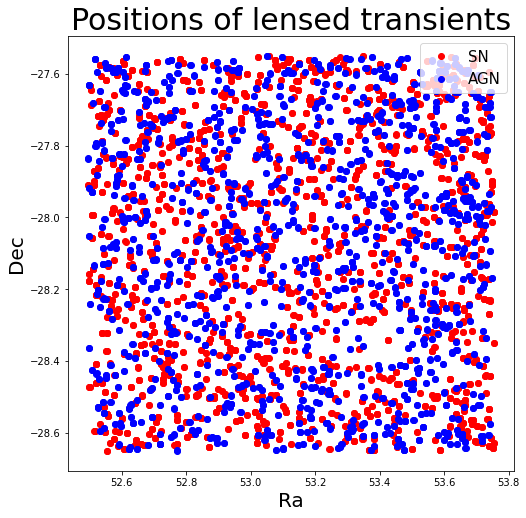

In [4]:
# Databases and location for truth catalogs
folder = '/global/cfs/cdirs/descssim/DC2/Run3.0i/truth_tables/'
truth_sn = 'updated_lensed_sne_truth.db'
truth_agn = 'updated_lensed_agn_truth.db'

# Set to true to visualize the tract:4848, patches:35,36,42,43 area.
show_patches = True

try:
    conn_sn = sqlite3.connect(folder+truth_sn)   
    conn_agn = sqlite3.connect(folder+truth_agn)   
except Exception as e:
    print(e)

#Now in order to read in pandas dataframe we need to know table name
cursor = conn_sn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

sn = pd.read_sql_query('SELECT * FROM lensed_sne', conn_sn)
conn_sn.close()

cursor = conn_agn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

agn = pd.read_sql_query('SELECT * FROM lensed_agn', conn_agn)
conn_agn.close()

fig, ax = plt.subplots()
plt.title('Positions of lensed transients', fontsize = 30)
plt.plot(sn.ra, sn.dec, 'or', label = 'SN')
plt.plot(agn.ra, agn.dec, 'ob', label = 'AGN')
plt.xlabel('Ra', fontsize = 20)
plt.ylabel('Dec', fontsize = 20)
plt.legend(fontsize = 15, loc="upper right")


plt.show()

In [5]:
def get_lens_radec(cat, butler, region=None, time=False, skymap=None):
    
    if skymap is None:
        skymap = butler.get("skymap")
    inumber = -1
    radec = []
    lens_radec = []
    for index, row in cat.iterrows():
        if row.image_number == inumber+1:
            radec.append([row.ra, row.dec])
        else: 
            #assert len(radec) in [2,4], f"there should be either 2 or 3 images in a lens system but {len(radec)} were found"
            lens_ra, lens_dec = np.mean(radec, axis=0)
            # Only saves the lenses that are in the processed regions
            if time == True:
                t = Time(row.t0+row.t_delay, format='mjd')
            else:
                t = None
            if is_in_region(lens_ra, lens_dec, butler, time=t, skymap=skymap):
                lens_radec.append({'coord': np.mean(radec, axis=0), 'image_pos':radec, 'n_images':inumber+1})
            radec = []
            radec.append([row.ra, row.dec])
            
        inumber = row.image_number
    return lens_radec

agn_lenses = get_lens_radec(agn, butler, skymap=skymap)
sn_lenses = get_lens_radec(sn, butler, skymap=skymap, time=True)

In [6]:
timespan = dafButler.Timespan(Time(np.double(59900.0), 
                                         format='mjd', 
                                         scale='utc'),
                                          Time(np.double(60100.0), 
                                         format='mjd', 
                                         scale='utc'))
ra = sn_lenses[2]['coord'][0]
dec = sn_lenses[2]['coord'][1]
radec_sky = SkyCoord(ra=ra * u.deg, dec= dec * u.deg)
dataset = query_transient(registry, radec_sky, timespan, myband = 'r', mesh_lvl=1, time_limit=None)

0it [00:00, ?it/s]

(13647, 12061)
(13647, 12061)
(9419, 12057)
(9420, 3592)
(9420, 3592)
(17899, -4892)
(17899, -4892)
(5201, 16288)
(5201, 16288)
(5204, 3589)
(5204, 3589)
(9427, -640)
(9427, -640)
(17896, 12059)
(943, 12062)
(943, 12062)
(-3275, 7803)
(-3275, 7803)
(9427, -4888)
(9427, -4888)
(13646, 3583)
(13646, 3583)
(13646, 3583)
(13646, 3583)
(9424, 16285)
(9424, 16285)
(-3276, -642)
(-3276, -642)
(5200, 12064)
(5200, 12064)
(13647, 7814)
(13647, 7814)
(947, 3577)


/tmp/ipykernel_37675/4029209387.py:27: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image.image.array))


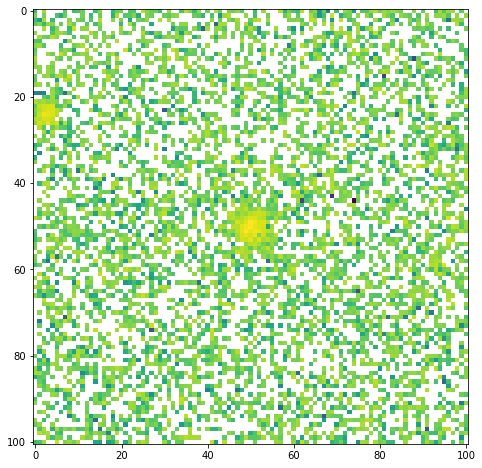

In [7]:
for r in tqdm(dataset):
    # extract individual exposure with the butler.
    calexp = butler.get('calexp', dataId=r.dataId)

    wcs = calexp.wcs
    cutout_extent = 50
    
    point = geom.SpherePoint(ra, dec, geom.degrees)
    xy = geom.PointI(wcs.skyToPixel(point))
    
    print(xy)
    
    if xy[0]<4072-cutout_extent and xy[1]<4000-cutout_extent and xy[0]>cutout_extent and xy[1]>cutout_extent:
    
        bbox = afwGeom.Box2I()
        bbox.include(afwGeom.Point2I(xy.x - cutout_extent,
                                     xy.y - cutout_extent))
        bbox.include(afwGeom.Point2I(xy.x + cutout_extent,
                                     xy.y + cutout_extent))
        mat = np.eye(3)
        mat[:2,:2] = wcs.getCdMatrix()
        transform = Affine2D(mat)
    
        image = calexp[bbox]
        break
        
plt.imshow(np.log10(image.image.array))
plt.show()

# Get lenses from the catalog and make sure they are available:

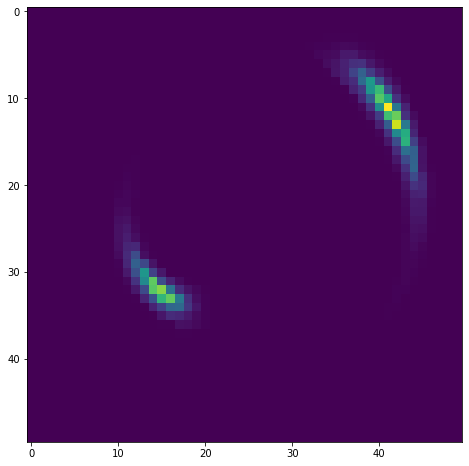

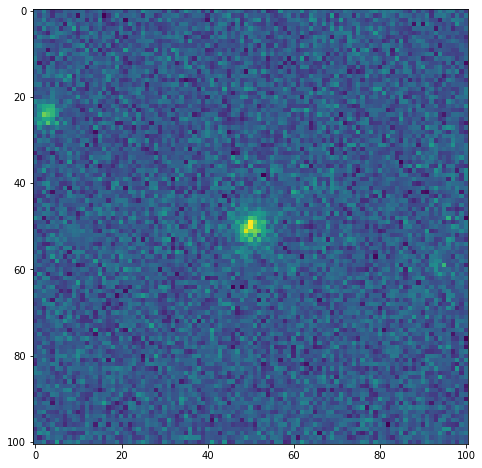

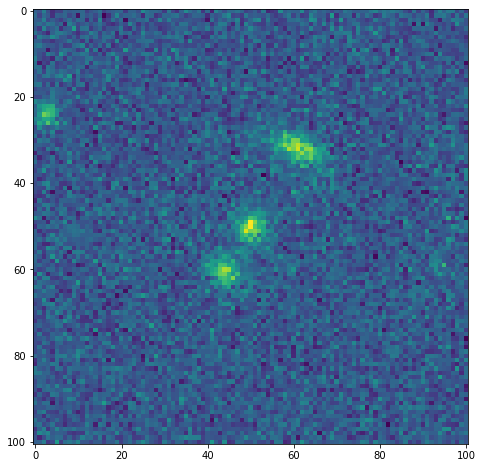

In [11]:
from desclamp import lens_sources as ls
from desclamp import postage as ps
from astropy.coordinates import SkyCoord
from lsst.pipe.tasks.insertFakes import _add_fake_sources
import astropy.units as u
import lsst
import galsim
import copy


lensing = ls.Lensing_frame(shape=(50,50))

lensing.from_galsim_parametric(1.5, 
                                profile='Spergel', 
                                shift=np.random.randn(2)*0.8, 
                                shear=np.random.randn(2)*0.2, 
                                half_light_radius=0.1+np.random.rand(1)*0.5, 
                                flux=10.)

lens_args = [{'theta_E': 1.5+np.random.rand(1)*2., 'e1': 0., 'e2': 0, 'center_x': 0, 'center_y': 0}]

lensed_image = lensing.lens_source(['SIE'], lens_args)
spectrum = np.array([200,240+np.random.randn(1)*25,260+np.random.randn(1)*25])+50
    
lensed_source = galsim.Image(lensed_image)

plt.imshow(lensed_source.array)
plt.show()

gsobj = galsim.InterpolatedImage(lensed_source, scale =0.2)
new_coadds = copy.deepcopy(image)

plt.imshow(image.image.array)
plt.show()

coadds_out = []

radec = lsst.geom.SpherePoint(radec_sky.ra.value, radec_sky.dec.value, lsst.geom.degrees)

_add_fake_sources(new_coadds, [(radec, gsobj.withFlux(spectrum[0]*100))])

coadds_out.append(new_coadds)


    
plt.imshow((coadds_out[0].image.array))
plt.show()